<a href="https://colab.research.google.com/github/tylerlum/Tray_Image_Classifier_A/blob/master/Tray_Image_Classifier_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
!pip install googledrivedownloader

In [114]:
# Download .7z files of images
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1smbsz8AJ-VGhKbtr7NTvAVzTI3auI_C4',
                                    dest_path='./tray-data/HiRes.7z')
gdd.download_file_from_google_drive(file_id='1wZ-AHv4yx_lXGeaqKzbTNuap6mpESyEq',
                                    dest_path='./tray-data/LoRes.7z')

In [118]:
!ls tray-data

checkpoint  HiRes.7z				  model.checkpoint.index
data_HiRes  LoRes.7z				  model.checkpoint.meta
data_LoRes  model.checkpoint.data-00000-of-00001  tray-data


!ls /content/tray-data

In [116]:
# Extract.7z file
!7z x /content/tray-data/HiRes.7z 
!7z x /content/tray-data/LoRes.7z 
%cd /content
!mv data_HiRes tray-data
!mv data_LoRes tray-data


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/tray-data/                             1 file, 987230795 bytes (942 MiB)

Extracting archive: /content/tray-data/HiRes.7z
--
Path = /content/tray-data/HiRes.7z
Type = 7z
Physical Size = 987230795
Headers Size = 38637
Method = LZMA2:26
Solid = +
Blocks = 1

  0%    
Would you like to replace the existing file:
  Path:     ./data_HiRes/multi/L01_S1_S4_S5/L1_S1_S4_S5_001.png
  Size:     174490 bytes (171 KiB)
  Modified: 2019-01-25 20:37:38
with the file from archive:
  Path:     data_HiRes/multi/L01_S1_S4_S5/L1_S1_S4_S5_001.png
  Size:     174490 bytes (171 KiB)
  Modified: 2019-01-25 20:37:38
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 
7-Zip [64] 16.0

In [0]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
#from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from kt_utils import *

from keras.losses import binary_crossentropy

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
from keras import optimizers
from keras import losses
from keras import metrics

In [120]:
# Setup for one hot encoding values
%cd /content/tray-data/data_LoRes/single
one_hot_encode = {}
types = [directory for directory in os.listdir('.')]
types.sort()
i = 0
for type in types:
  one_hot_encode[type] = i
  i = i + 1

/content/tray-data/data_LoRes/single


In [121]:
!mv checkpoint /content
!mv model* /content

mv: cannot stat 'checkpoint': No such file or directory
mv: cannot stat 'model*': No such file or directory


In [122]:
# Convert pngs into numpy arrays in full_dataset dict
%cd /content/tray-data/data_LoRes/single
import os
full_dataset = {}
P = 0
for directory in os.listdir('.'):
  x_data = []
  y_data = []
  for png in os.listdir('/content/tray-data/data_LoRes/single/' + directory):
    im = cv2.imread('/content/tray-data/data_LoRes/single/' + directory + '/' + png)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    x_data.append(im)
    a = np.zeros((len(types), 1))
    a[one_hot_encode[directory]] = 1
    y_data.append(a)
  full_dataset[str(directory) + "_x"] = x_data
  full_dataset[str(directory) + "_y"] = y_data

/content/tray-data/data_LoRes/single


(64, 64, 3)


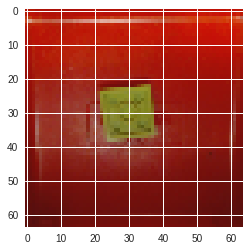

In [123]:
# Example image
print(full_dataset['L11_x'][0].shape)
plt.imshow(full_dataset['L11_x'][10])

plt.imshow(b[1])

In [124]:
# Fill in training and test data sets

# Initialize 
X_train = None
X_test = None
Y_train = None
Y_test = None
  
# Choose number of pictures and classes
num_pictures = 70  # per class
num_classes = 6  # number of classes used for recognition

class_num = 0
keys_x = [key for key in full_dataset if not key.find("_x") == -1]
keys_x.sort()
for key_x in keys_x:
  # Finish after getting class_num classes
  if class_num >= 6:
    break
  class_num = class_num + 1
  i = 0
  
  # Add images from this class
  for im in full_dataset[key_x]:
    
    # Add to training set
    if i <= num_pictures:
      # Initialize array
      if X_train is None:
        X_train = np.array([im])
        a = np.zeros((num_classes, 1))
        a[one_hot_encode[key_x[:-2]]] = 1
        Y_train = np.array([a])
      # Append to array
      else:
        X_train = np.append(X_train, [im], axis=0)
        a = np.zeros((num_classes, 1))
        a[one_hot_encode[key_x[:-2]]] = 1
        Y_train = np.append(Y_train, [a], axis=0)
        #print(X_train.shape)
        
    # Add to test set
    elif i <= num_pictures * 3 / 2:  ## 3:2 ratio of train:test size
      # Initialize array
      if X_test is None:
        X_test = np.array([im])
        a = np.zeros((num_classes, 1))
        a[one_hot_encode[key_x[:-2]]] = 1
        Y_test = np.array([a])
      # Append to array
      else:
        X_test = np.append(X_test, [im], axis=0)
        a = np.zeros((num_classes, 1))
        a[one_hot_encode[key_x[:-2]]] = 1
        Y_test = np.append(Y_test, [a], axis=0)
        #print(X_test.shape)
    else:
      break
    i = i + 1
    
Y_train = Y_train[:, :, 0]
Y_test = Y_test[:, :, 0]
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(426, 64, 64, 3)
(426, 6)
(196, 64, 64, 3)
(196, 6)


[0. 1. 0. 0. 0. 0.]


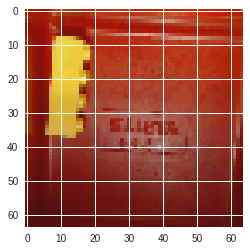

In [125]:
# Example image and label
index = 100
plt.imshow(X_train[index])
print(Y_train[index, :])

In [0]:
# Randomize order in datasets (TODO: shuffle earlier on, so mix train and test)
import random
import copy

## Mix up data
num_switches = 200

# Change order in train set
for i in range(0, num_switches):
  rand1 = random.randint(0, X_train.shape[0]-1)
  rand2 = random.randint(0, X_train.shape[0]-1)
  temp = copy.copy(X_train[rand1])
  X_train[rand1] = X_train[rand2]
  X_train[rand2] = temp
  
  temp = copy.copy(Y_train[rand1, :])
  Y_train[rand1, :] = Y_train[rand2, :]
  Y_train[rand2, :] = temp
  
  #print(str(rand1) + " " + str(rand2))
  
# Change order in test
for i in range(0, num_switches):
  rand1 = random.randint(0, X_test.shape[0]-1)
  rand2 = random.randint(0, X_test.shape[0]-1)
  temp = copy.copy(X_test[rand1])
  X_test[rand1] = X_test[rand2]
  X_test[rand2] = temp
  
  temp = copy.copy(Y_test[rand1, :])
  Y_test[rand1, :] = Y_test[rand2, :]
  Y_test[rand2, :] = temp
  
  #print(str(rand1) + " " + str(rand2))

[1. 0. 0. 0. 0. 0.]


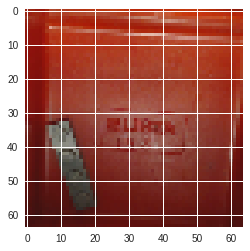

In [126]:
# Example view test image and label
index = 12
plt.imshow(X_test[index])
print(Y_test[index, :])

[0. 0. 1. 0. 0. 0.]


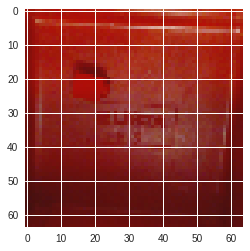

In [127]:
# Example view train image and label
index = 160
plt.imshow(X_train[index])
print(Y_train[index, :])

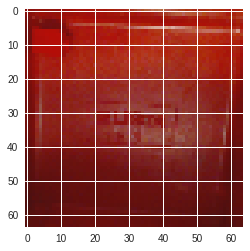

In [128]:
# Compare to full_dataset image and label
plt.imshow(full_dataset['L03_x'][0])

In [0]:
# Standardize data to have feature values between 0 and 1.
train_x = X_train/255.
test_x = X_test/255.

train_y = Y_train
test_y = Y_test

In [130]:
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))

train_x's shape: (426, 64, 64, 3)
test_x's shape: (196, 64, 64, 3)
train_y's shape: (426, 6)
test_y's shape: (196, 6)


In [0]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='same', name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [0]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1,1), strides=(1,1), padding='valid', name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1,1), strides=(s,s), padding='valid', name=conv_name_base+'1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [0]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 23):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f=3, filters=[128,128,512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256,256,1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='d')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='e')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f=3, filters=[512,512,2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
    X = identity_block(X, 3, [512,512,2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2,2), name='avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [0]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

In [0]:
#opt = optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
#loss = losses.mean_squared_logarithmic_error
#model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
#model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[metrics.categorical_accuracy])
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_x's shape: (426, 64, 64, 3)
test_x's shape: (196, 64, 64, 3)
train_y's shape: (426, 6)
test_y's shape: (196, 6)
[1. 0. 0. 0. 0. 0.]


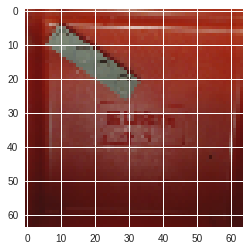

In [0]:
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))

plt.imshow(train_x[0])

print(train_y[0,:])

In [0]:
model.fit(train_x, train_y, epochs = 50, batch_size = 32)

Epoch 1/50
426/426 [==============================] - 18s 41ms/step - loss: 3.0355 - acc: 0.3592
Epoch 2/50
426/426 [==============================] - 3s 8ms/step - loss: 0.8862 - acc: 0.6479
Epoch 3/50
426/426 [==============================] - 3s 8ms/step - loss: 0.2824 - acc: 0.9178
Epoch 4/50
426/426 [==============================] - 3s 8ms/step - loss: 0.1054 - acc: 0.9624
Epoch 5/50
426/426 [==============================] - 3s 8ms/step - loss: 0.3464 - acc: 0.9390
Epoch 6/50
426/426 [==============================] - 3s 8ms/step - loss: 0.2217 - acc: 0.9554
Epoch 7/50
426/426 [==============================] - 3s 8ms/step - loss: 0.0673 - acc: 0.9789
Epoch 8/50
426/426 [==============================] - 3s 8ms/step - loss: 0.1820 - acc: 0.9390
Epoch 9/50
426/426 [==============================] - 3s 8ms/step - loss: 0.0555 - acc: 0.9859
Epoch 10/50
426/426 [==============================] - 3s 8ms/step - loss: 0.1568 - acc: 0.9671
Epoch 11/50
426/426 [==========================

In [0]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

196/196 [==============================] - 3s 16ms/step
Loss = 0.15543056030434613
Test Accuracy = 0.9795918367346939


In [0]:
preds = model.evaluate(train_x, train_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

426/426 [==============================] - 1s 1ms/step
Loss = 0.12774846492938594
Test Accuracy = 0.9647887326742002


[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Input image shape: (64, 64, 3)
Input image shape: (1, 64, 64, 3)
[[2.4446487e-10 9.9461573e-01 8.0041258e-07 5.3813169e-03 2.0535615e-06
  1.3579771e-07]]


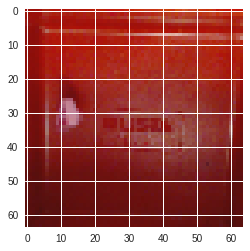

In [0]:
index = 20
classname = 'L04'
plt.imshow(full_dataset[classname+'_x'][index])
print(full_dataset[classname+'_y'][index])
x = full_dataset[classname+'_x'][index] / 255.
print('Input image shape:', x.shape)
x = np.array([x])
print('Input image shape:', x.shape)

print(model.predict(x))

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

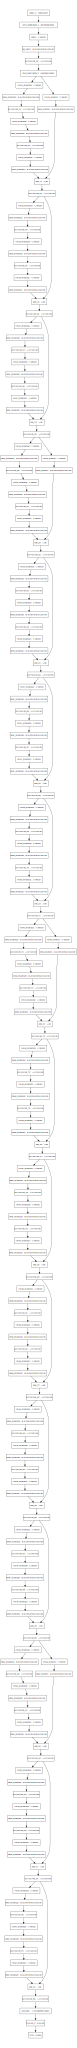

In [0]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))